# Problem Statement
SuperCabs is a leading app-based cab provider in a large Indian metro city. The goal of our project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day. 

## Assumptions:
 1. Taxis are electric cars. It can run non stop for 30 days (i.e. 720 hours). Then it needs to recharge itself.If the driver is completeing a trip at that time , he'll finish the trip and then stop for charging. Therefore, there is one and only ** Terminal state** that defines an **episode** at end of 720 hr ride (or after the last drive crossing 720th hour).
 2. There are only five locations where a driver can pick-up or drop 
 3. All decisisons are made at hourly intervals
 4. The time taken to travel from one place to other place depends on place (pick up/ drop), hour of the day and day of the week. The travel duration is given through **TM.npy** file.

 ## Important definitions
 ### State
 The state space is defined by the drivers current location along with the time components
 $$ S = X_{i} T_{j} D_{k} $$ 
 Xi = i th location $i= 0, 1 ,2 ,3, 4$ <br>
 Tj = j th hour of the day $j= 0, 1, 2, ...., 22, 23$ <br>
 Dk = kth day $k= 0, 1, 2, 3, ...., 29$<br>

 ### Action
 Action is a combination of pick up and drop
 $$ A = { (p,q): p= 0,1,2,..,4 \ and \ q=0,1,...,4 , \ p \neq q } $$
 However (0,0) is always an option to driver to rmail offline , i.e. take no request. <br>

 ### Requests
 The number of request received from a location follows a Poisson distribution: <br>


 |Location|λ|
 |---|---|
 |0|2|
 |1|12|
 |2|4|
 |3|7|
 |4|3|

 If the number of requests > 15 , then only first 15 requests are considered.
 If the number of requests is 0 , then driver stays offline (0,0).
 

    




# Deep RL
Statrt of deep re-inforcement learning code.

## Import necessary libraries for this notebook

In [1]:
# Import Libraries
import numpy as np
import random
import math
import time

# Library to store experiences from environment agent interaction
from collections import deque
# Save model
import pickle

#Libraries for DQN
import keras
from keras import layers, Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam


from keras import backend as K
import tensorflow.compat.v1 as tf



# Plot
import matplotlib.pyplot as plt

# import the MDP environment
from Env import CabDriver

env= CabDriver()

Important step to accelerate run time

In [2]:
tf.disable_v2_behavior()
jobs = 8 # Play around with this number
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Load time matrix
TM= np.load('TM.npy')

## Time Matrix

Time to travel from location p to q depends on time of the day and day of the week. This data is provided as **TM.npy** file. We assume Sunday is day 0.

In [4]:
print("Time required to travel from location 2 to location 1 at 5 am on Monday: ", TM[1][0][4][1])

Time required to travel from location 2 to location 1 at 5 am on Monday:  3.0


In [5]:
# Sanity check
print("What is trip time if we stay on the same location: ", TM[1][1][0][1])

What is trip time if we stay on the same location:  0.0


In [6]:
print(type(TM))
print("Maximum transit time: ",TM.max())
print("Minimum transit time: ", TM.min())
print("Average transit time: ",TM.mean())
print("Varince of transit time: ",TM.var())

<class 'numpy.ndarray'>
Maximum transit time:  11.0
Minimum transit time:  0.0
Average transit time:  3.0542857142857143
Varince of transit time:  7.93705306122449


# Checking environment
A MDP environment is created separately and it is provided as **env.py** file in the source. <br>
**Parameters** <br>
Number of location: 5 <br>
Total hours in a day: 24 <br>
Number of days in a week: 7 <br>
Fuel cost per hour: 5 unit <br>
Revenue from a passenger per hour: 9 unit

In [7]:
print("Total number of actions possible: ", len(env.action_space))
print("Total number of states possible: ", len(env.state_space))

Total number of actions possible:  21
Total number of states possible:  840


In [8]:
# State encoding for architecture 1
print("Encodes state (1,4,1), i.e. location 2, 5 am, Monday: ",env.state_encod_arch1(state=[1,4,1]))

Encodes state (1,4,1), i.e. location 2, 5 am, Monday:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [9]:
print("Requests received from state (1,4,1): [Index of possible actions from action space, actions] \n", env.requests([1,4,1]))

Requests received from state (1,4,1): [Index of possible actions from action space, actions] 
 ([10, 2, 19, 15, 1, 17, 14, 4, 9, 18, 6, 0], [[2, 1], [0, 2], [4, 2], [3, 2], [0, 1], [4, 0], [3, 1], [0, 4], [2, 0], [4, 1], [1, 2], [0, 0]])


In [10]:
print("Next state after the trip from current state (1,4,1) after completing the action/ trip [2,1]: (next state, wait_time, transit_time, ride time) \n", env.next_state_func([1,4,1], [2,1], TM))

Next state after the trip from current state (1,4,1) after completing the action/ trip [2,1]: (next state, wait_time, transit_time, ride time) 
 ([1, 19, 1], 0, 6.0, 9.0)


In [11]:
print("Reward of the trip: ", env.reward_func([1,4,1], [2,1], TM))

Reward of the trip:  6.0


In [12]:
print("Rewards earned, next state , total trip duration ", env.step([1,4,1], [2,1], TM))

Rewards earned, next staep , total trip duration  (6.0, [1, 19, 1], 15.0)


## Agent interaction to environment - Deep Q net and Q learning

1. Input to agent class: State and Action Size <br>
2. Hyperparameters: discount factor, learning rate , epsilon decay rate, batch size <br>
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
7. Initialise your input and output batch for training the model
8. Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
Get Q(s', a) values from the last trained model
9. Update the input batch as your encoded state and output batch as your Q-values. Then fit your DQN model using the updated input and output batch.

In [13]:
# Build DQN and perform Q learning

class DQNAgent:
  def __init__(self, state_size, action_size):
    # Define size of state and action
    self.state_size = state_size
    self.action_size = action_size

    # Specify hyperparameters for  for DQN
    self.discount_factor = 0.95
    self.learning_rate = 0.01
    self.epsilon_max = 1.0
    self.epsilon_decay = -0.0006
    self.epsilon_min = 0.0001
    self.epsilon = 0 
    self.batch_size = 32
    # State to track [2,3,4]
    self.track_state= np.array(env.state_encod_arch1([2,3,4])).reshape(1, self.state_size)

    self.store_states_tracked = []

    # Replay buffer
    self.memory = deque(maxlen=2000)

    # DQN network
    self.model = self.build_model()

  # Approximate Q function using network

  def build_model(self):
    model =  Sequential()
    model.add(Dense(32, activation='relu', input_dim= self.state_size, kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(self.action_size, activation='relu',kernel_initializer='he_uniform'))
    model.compile(loss='mse', optimizer= Adam(lr=self.learning_rate))
    model.summary
    return model

  # Epsilon greedy action
  def get_action(self, state):
    z= np.random.rand()
    # Actions from the state
    possible_actions_index, action = env.requests(state)
    if z > self.epsilon:
      # best action
      state_encoded = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
      #q-value for all actions
      q_value = self.model.predict(state_encoded)
      
      q_value_possible_actions= [q_value[0][i] for i in possible_actions_index]
      # best possible action
      agent_action_id= possible_actions_index[np.argmax(q_value_possible_actions)]
      #agent_action= env.action_space[best_action_index]


    else:
      agent_action_id = random.choice(possible_actions_index)

    return agent_action_id

  # Add experience to memory
  def append_sample(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # Train the model
  def train_model(self):
    # Start training if memory size is higher than batch size
    if len(self.memory) > self.batch_size:
      # Draw a random sample of to generate mini_batch
      mini_batch = random.sample(self.memory, self.batch_size)
      #Initialize input  and target 
      update_input = np.zeros(shape=(self.batch_size, self.state_size))
      update_target = np.zeros(shape=(self.batch_size, self.state_size))
      #Initialize actions , rewards and terminal state status
      actions, rewards, done =[], [], []

      #Load experiences from memory
      for i in range(self.batch_size):
       
        update_input[i] = env.state_encod_arch1(mini_batch[i][0])
        actions.append(mini_batch[i][1])
        rewards.append(mini_batch[i][2])
        update_target[i]= env.state_encod_arch1(mini_batch[i][3])
        done.append(mini_batch[i][4])
      
      # Predict the q_value from state s
      target = self.model.predict(update_input)
      # target for next state
      target_qval = self.model.predict(update_target)

      # Update q_values using Q learning:
      for i in range(self.batch_size):
        if done[i]: #terminal state
          target[i][actions[i]]= rewards[i]
        else:
          target[i][actions[i]]= rewards[i] + self.discount_factor * np.max(target_qval[i])
      # Update the model
      self.model.fit(update_input, target, batch_size= self.batch_size, epochs=1, verbose=0)

  def save_tracked_states(self):
    q_value= self.model.predict(self.track_state)
    # 3 rd action from action space i.e action 0,2
    self.store_states_tracked.append(q_value[0][2])

  def save_model(self, name):
    self.model.save_weights(name)
      



## Start training
for episode in range(Episodes):

while not in terminal_state:

1. Pick epsilon-greedy action from possible actions for the current state
2. Evaluate your reward and next state
3. Append the experience to the memory
4. Train the model by calling function agent.train_model
5. Keep a track of rewards, Q-values

In [14]:
# Declare storage spaces and parameters
#action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = 36 # No. of place + no. of hours + no. of days
action_size = len(env.action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# Number of episodes 
n_episodes = 10000
# Time to terminal state
time_to_terminal = 24*30

# Store episode wise rewards episodes
epoisode_wise_rewards, episode_count = [], []


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
start_time = time.time()

for ep in range(n_episodes):

  done = False
  ep_reward= 0 # reward of an episode
  total_time= 0

  # reset at the start of each episode
  env = CabDriver()
  action_space, state_space, state = env.reset()

  while not done:
    # find epsilon greedy action by agent
    agent_action= agent.get_action(state)

    # Evaluate reward, next_state and trip_time
    reward_received, next_state, trip_duration = env.step(state, env.action_space[agent_action], TM)

    total_time += trip_duration

    if total_time > time_to_terminal :
      # Terminal state
      done = True
    else:
      # Add the new learning to the experience
      agent.append_sample(state, agent_action, reward_received, next_state, done)
      # train model
      agent.train_model()

      # Track reward
      ep_reward += reward_received
      #Update state
      state = next_state

  # Calculate total reward in an episode and store
  epoisode_wise_rewards.append(ep_reward)
  #Episode
  episode_count.append(ep)

  # Update epsilon
  agent.epsilon = (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * ep)

  # Print result after every 50 episodes
  if (ep+1) % 50 ==0:
    print("At {0}th episode the total reward earned is {1}. Time taken to complete this episode is {2} and the length of memory is {3}, epsioln value is {4} ".format(ep+1, 
                                                                                                                                                                      ep_reward, 
                                                                                                                                                                      total_time,
                                                                                                                                                                      len(agent.memory),
                                                                                                                                                                      agent.epsilon))
    
  # Save the Q_value of the state, action pair we are tracking for every 5 th episode
  if (ep + 1) % 10 == 0:
    agent.save_tracked_states()


  if (ep +1) % 2000 == 0:
    print("Saving Model {}".format(ep+1))
    agent.save_model(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)                                                                                                                                                                  

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


At 50th episode the total reward earned is -177.0. Time taken to complete this episode is 728.0 and the length of memory is 2000, epsioln value is 0.9709308727862163 
At 100th episode the total reward earned is -162.0. Time taken to complete this episode is 725.0 and the length of memory is 2000, epsioln value is 0.9422355288797383 
At 150th episode the total reward earned is -66.0. Time taken to complete this episode is 725.0 and the length of memory is 2000, epsioln value is 0.9143882605520585 
At 200th episode the total reward earned is 90.0. Time taken to complete this episode is 731.0 and the length of memory is 2000, epsioln value is 0.8873640033819347 
At 250th episode the total reward earned is 45.0. Time taken to complete this episode is 727.0 and the length of memory is 2000, epsioln value is 0.8611384337137219 
At 300th episode the total reward earned is 138.0. Time taken to complete this episode is 721.0 and the length of memory is 2000, epsioln value is 0.8356879467644394 

### Save the final model for submission

In [23]:
weights=agent.save_model(name="model_weights.pkl")

In [24]:
with open('final_model.pkl', 'wb') as file:
        pickle.dump(weights, file, pickle.HIGHEST_PROTOCOL)

In [25]:
agent.model.save_weights('weights.h5')

## Check Convergence
We can plot the (state, action) value we tracked to check the convergence

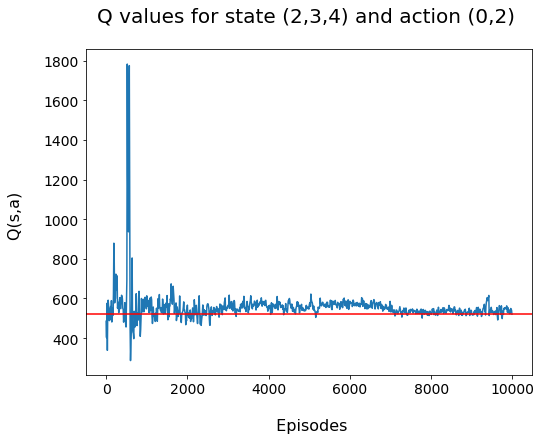

In [64]:
plt.figure(figsize=(8,6))
plt.title("Q values for state (2,3,4) and action (0,2) \n", size=20)

plt.plot(np.arange(1,len(agent.store_states_tracked)*10 + 1,10), agent.store_states_tracked)

plt.xlabel("\n Episodes", size=16)
plt.ylabel ("Q(s,a) \n", size=16)
plt.axhline(y=520, color='r')
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

## Track total rewards per episode

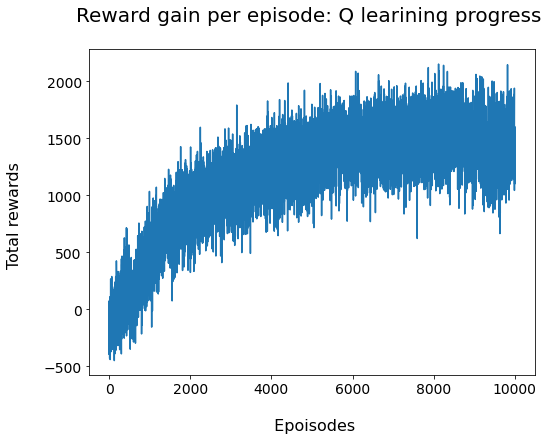

In [27]:
plt.figure(figsize=(8,6))
plt.title("Reward gain per episode: Q learining progress \n", size=20)
plt.plot(episode_count,epoisode_wise_rewards)
plt.xlabel("\n Epoisodes", size=16)
plt.ylabel ("Total rewards \n", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

## Epsilon decay
The action of the agent in a Q learning model is taken by a ϵ-greedy rule. If ϵ is too small then the chance of exploration is little, on the other hand if ϵ is too large then model will only explore (i.e. no exploitation of best valued action). Thus ideally at teh start of model building we allow sufficient exploration to give a chance to visit variety of states and actions. However with enough experience in memory , we try to always find the action that provides maximum rewards. <br>
As a thumb rule initial ~50% of the episodes should allow chance to explore (i.e ϵ > 0.1)

In [21]:
decay_rate = 0.0006
# Maximum and minimum epsilon
max_e= 1
min_e = 0.00001

# Number of episodes in the experiment
episodes= 10000

times = np.arange(0, episodes)
epsilon=[]

for i in times:
  epsilon.append((max_e - min_e)*np.exp(-decay_rate*i))

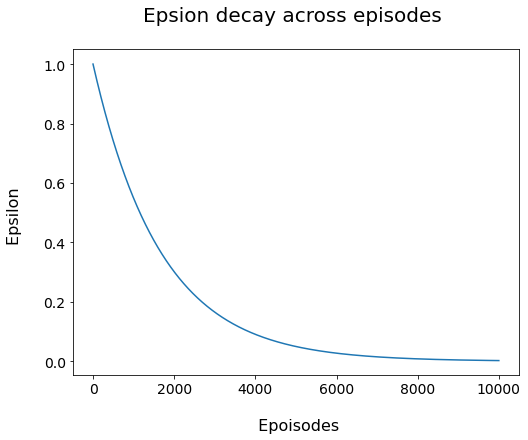

In [22]:
plt.figure(figsize=(8,6))
plt.title("Epsion decay across episodes \n", size=20)
plt.plot(times, epsilon)
plt.xlabel("\n Epoisodes", size=16)
plt.ylabel ("Epsilon \n", size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

## Reusing model weights to predict a state action value

In [125]:
from keras.models import load_model
agent.model.save("DQN.h5")
loaded_model = load_model("DQN.h5")
loaded_model.predict(np.array(env.state_encod_arch1([2,3,4])).reshape(1, 36))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[  0.     , 538.87286, 520.4663 , 531.65137, 508.69302, 515.251  ,
        503.77518, 496.90195, 495.87384, 528.6594 , 551.44244, 527.68536,
        525.3103 ,   0.     ,   0.     , 513.4109 , 514.6059 , 512.3801 ,
        524.4699 , 522.5074 , 512.1609 ]], dtype=float32)